In [139]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

import math, time, copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR, MultiStepLR, CosineAnnealingLR, CosineAnnealingWarmRestarts
from collections import defaultdict
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [140]:
# --- load & basic columns ---
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
df = pd.read_csv("data.csv")
FEATURE_COLS = [c for c in df.columns if c != "Strength"]
TARGET_COL = "Strength"
df.columns

Index(['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer',
       'Coarse Aggregate', 'Fine Aggregate', 'Age', 'Strength'],
      dtype='object')

# Task 1 - Data Preparation

### 1. Data inspection and splitting

In [ ]:

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
X = df[FEATURE_COLS].values
y = df[TARGET_COL].values

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=74
)

X_vld, X_test, y_vld, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=74
)

print(X_train.shape)
print(X_vld.shape)
print(X_test.shape)

(618, 8)
(206, 8)
(206, 8)


### 2. Feature Visualization

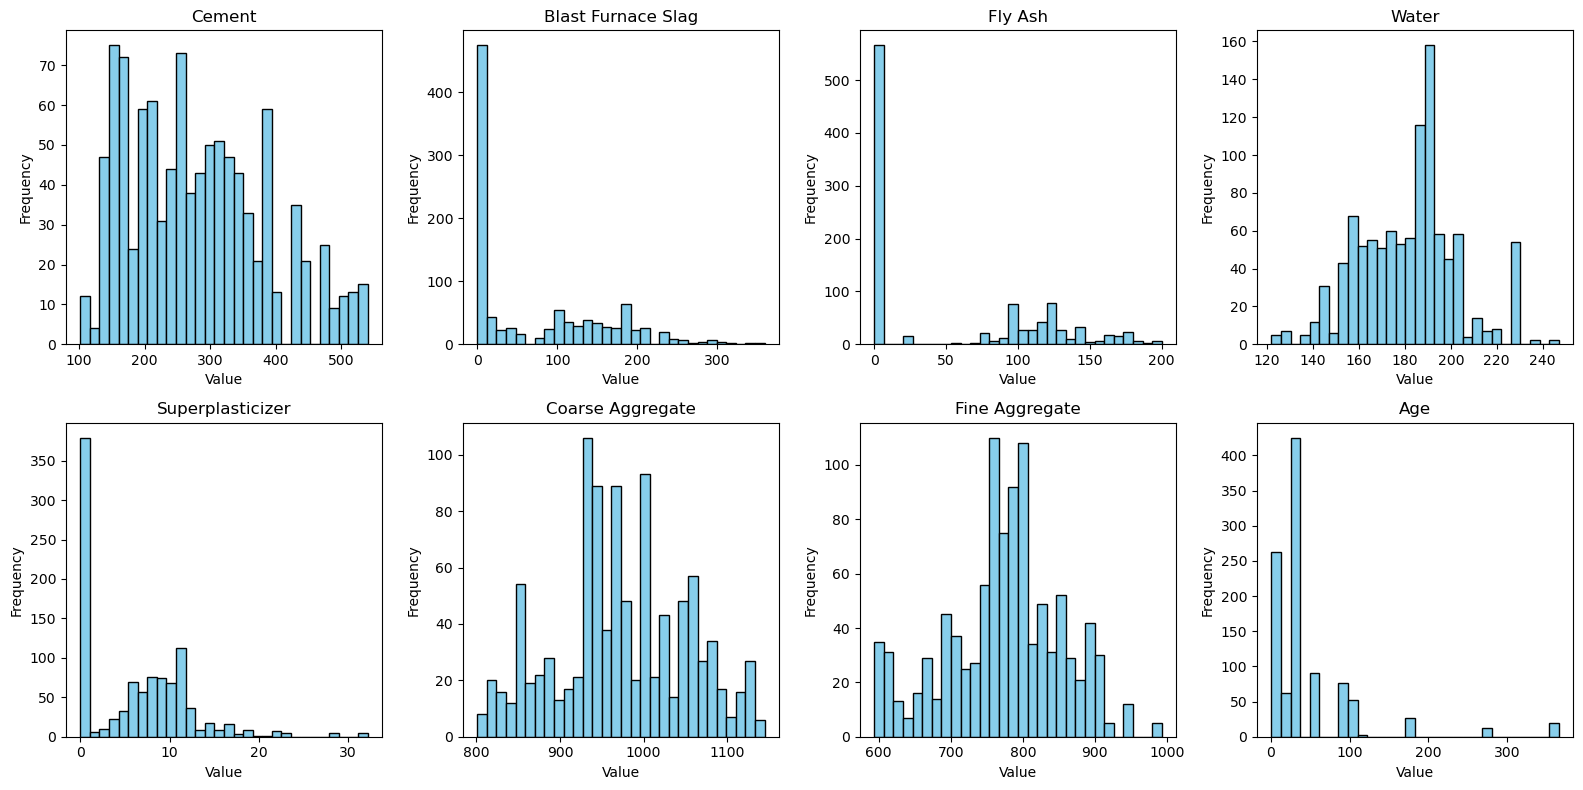

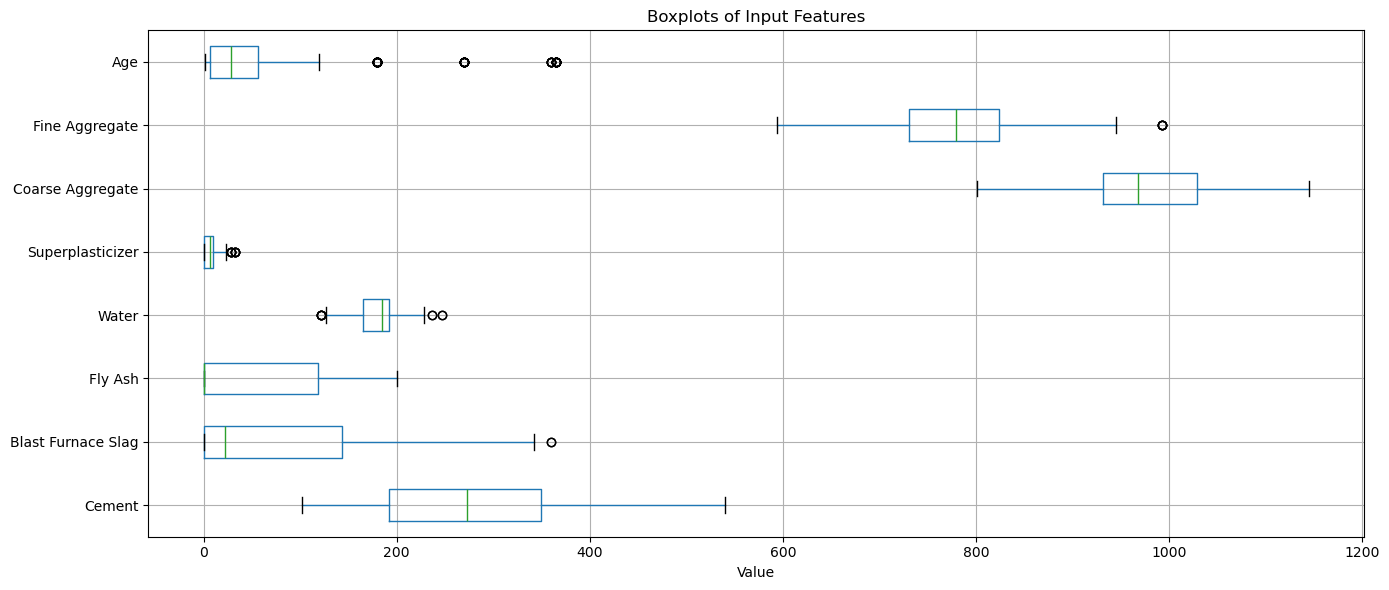

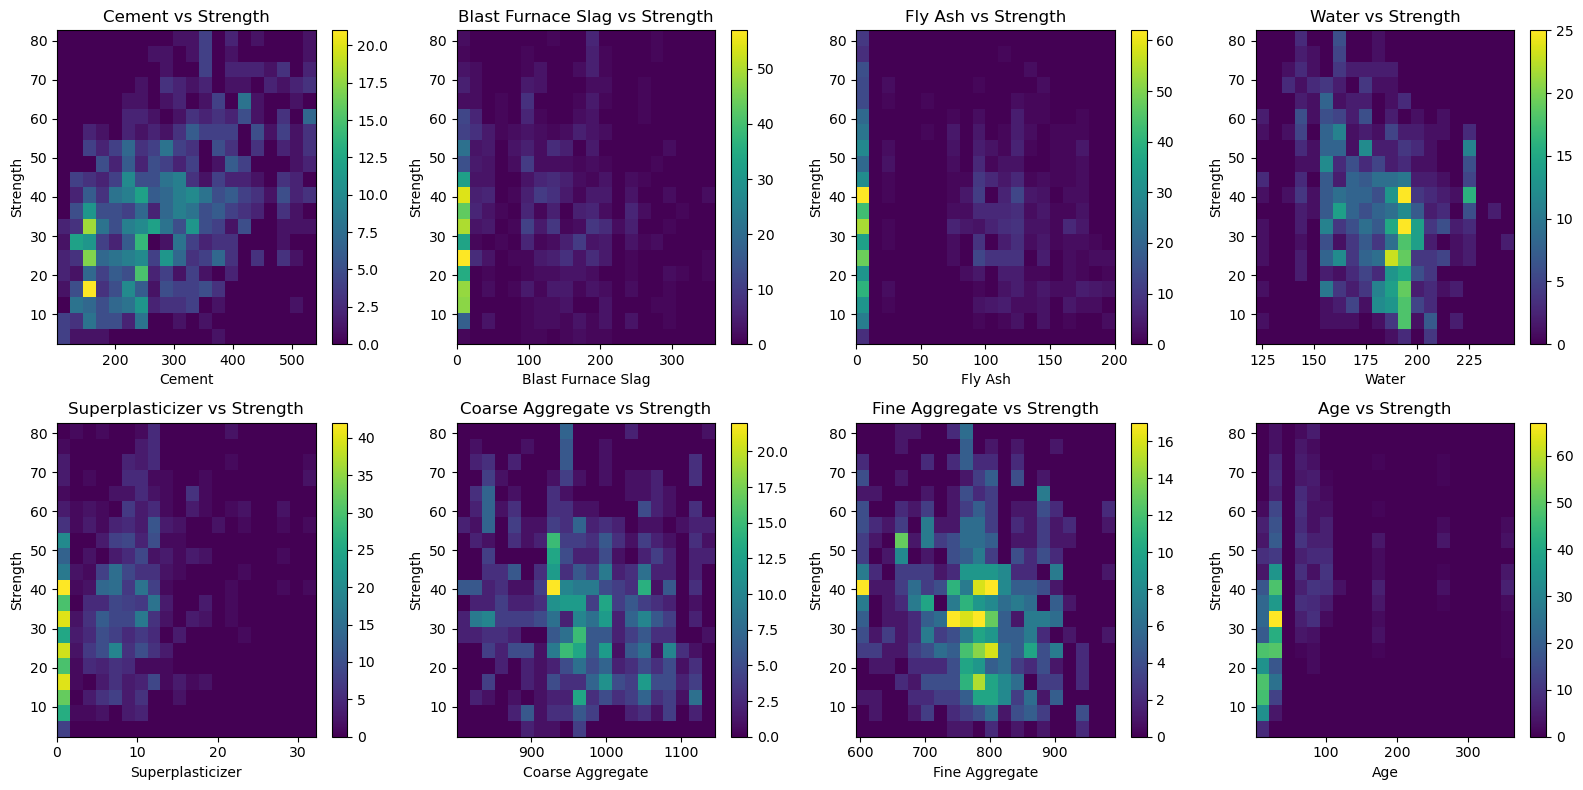

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(FEATURE_COLS):
    axes[i].hist(df[col], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
df[FEATURE_COLS].boxplot(vert=False)

plt.title("Boxplots of Input Features")
plt.xlabel("Value")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(FEATURE_COLS):
    counts, xedges, yedges, image = axes[i].hist2d(
        df[col], df[TARGET_COL], bins=20
    )
    
    axes[i].set_title(f"{col} vs Strength")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Strength")
    
    plt.colorbar(image, ax=axes[i])

plt.tight_layout()
plt.show()



### Task 3 - Feature Scaling
By scaling features to a similar range, we prevent features with larger values 
from dominating the learning process and ensure each feature contributes equally. 

In [ ]:

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_vld_scaled = scaler.transform(X_vld)
X_test_scaled = scaler.transform(X_test)

print(f"Mean of X_train_scaled: {X_train_scaled.mean():.2f}") 
print(f"Std of X_train_scaled: {X_train_scaled.std():.2f}") 

Mean of X_train_scaled: 0.00
Std of X_train_scaled: 1.00


### Task 4 -  DataLoader Construction
 A simple desc: we first convert our dataset to tensors, then Make a dataset out of those Tensors
 and for last we choose a batch size and finally a data loader is a loop which sends our data in batches to tne NN

In [144]:

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_vld_t   = torch.tensor(X_vld_scaled, dtype=torch.float32)
y_vld_t   = torch.tensor(y_vld, dtype=torch.float32).view(-1, 1)

X_test_t  = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


train_dataset = TensorDataset(X_train_t, y_train_t)
vld_dataset   = TensorDataset(X_vld_t, y_vld_t)
test_dataset  = TensorDataset(X_test_t, y_test_t)

batch_size = 64  #maybe change, idk

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(vld_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Batches in train_loader: {len(train_loader)}")


Batches in train_loader: 10


# Task 2

### Task 2.1 - Model Design and Training Setup

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
class OurNN(nn.Module):  
    def __init__(self, input_dim, hidden_dims, activation=nn.ReLU):
        super().__init__()
        self.layers = nn.ModuleList()
        prev_dim = input_dim

        for h_dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, h_dim))
            prev_dim = h_dim
        
        self.out = nn.Linear(prev_dim, 1)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            x = torch.relu(x) 
            
        return self.out(x)
    


## Helper functions for gradient tracking
Following the official [PyTorch Tutorial](https://docs.pytorch.org/tutorials/intermediate/visualizing_gradients_tutorial.html), the following functions help you with gradient analysis.

They add a _hook_ to the backward pass, which stores the gradients of each layer in a list. This will be done at each backward pass, so once per mini-batch. The function `get_grads_per_layer(grads)`averages



In [146]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
def hook_forward(module_name, grads, hook_backward):
    def hook(module, args, output):
        """Forward pass hook which attaches backward pass hooks to intermediate tensors"""
        if not torch.is_grad_enabled():
            return
        output.register_hook(hook_backward(module_name, grads))
    return hook

def hook_backward(module_name, grads):
    def hook(grad):
        """Backward pass hook which appends gradients"""
        grads[module_name].append(grad.detach().abs().mean().cpu())
    return hook

def register_gradient_hook(model, hook_forward, hook_backward):
    """Register forward pass hook (which registers a backward hook) to model outputs

    Returns:
        - layers: a dict with keys as layer/module and values as layer/module names
                  e.g. layers[nn.Conv2d] = layer1.0.conv1
        - grads: a list of tuples with module name and tensor output gradient
                 e.g. grads[0] == (layer1.0.conv1, tensor.Torch(...))
    """
    from collections import defaultdict
    layers = dict()
    grads = defaultdict(list)
    for name, layer in model.named_modules():
        # skip containers / wrappers; only hook leaves
        if not any(layer.children()):
            layers[layer] = name
            layer.register_forward_hook(hook_forward(name, grads, hook_backward))
    return layers, grads


def aggregate_grads_epoch(grads_dict):
    """
    Combine all (mean|grad|) scalars collected across the entire epoch
    into a single scalar per layer.
    """
    averaged = []
    for layer_name, vals in grads_dict.items():
        if len(vals) == 0:
            continue
        # vals is a list of 0-D CPU tensors
        avg = torch.stack(vals).mean().item()  # float for easy logging
        averaged.append({"layer": layer_name, "grad": avg})
    return averaged

In [ ]:

# --- device ---
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# how often to print per-epoch progress
log_every = 1 


# helper function to automate optimizer creation
def make_optimizer(name, params, lr, momentum=0.0):
    n = name.lower()
    if n == "sgd":
        return torch.optim.SGD(params, lr=lr, momentum=0.0)
    if n in ("sgd_momentum",):
        return torch.optim.SGD(params, lr=lr, momentum=momentum)
    if n in ("nesterov_sgd", "nesterov"):
        return torch.optim.SGD(params, lr=lr, momentum=momentum, nesterov=True)
    if n == "rmsprop":
        return torch.optim.RMSprop(params, lr=lr)
    if n == "adam":
        return torch.optim.Adam(params, lr=lr)
    raise ValueError(f"Unknown optimizer: {name}")



# --- training helper ---
def train_one_model(input_dim, hidden, lr, max_epochs, 
                    train_loader, val_loader, 
                    scheduler_type=None,
                    optimizer_name="adam", momentum = 0.9, verbose=True):
    
    # ------ TODO: create model, criterion and optimizer ------
    seed = 42
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    model = OurNN(input_dim=input_dim, hidden_dims=hidden, activation=nn.ReLU).to(device=device)
    criterion = nn.MSELoss()
    optimizer = make_optimizer(optimizer_name, model.parameters(), lr, momentum)

    # ------ end TODO ------
    scheduler = None
    if scheduler_type:
        scheduler = scheduler_type(optimizer)

    history = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "gradients": [],
    }
    _, grads = register_gradient_hook(model, hook_forward, hook_backward)


    best_state = None
    best_val = math.inf
    t0 = time.time()

    for epoch in range(1, max_epochs + 1):
        # train
        model.train()
        running_train = 0.0
        n_train_batches = 0

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            
            grads.clear()   # this is only for the gradient tracking

            # ------ TODO: execute the main update steps ------
            # Don't forget to reset the gradient! 
            optimizer.zero_grad()
            y_hat = model(xb)
            loss = criterion(y_hat, yb)
            loss.backward()
            optimizer.step()
            # ------ end TODO ------

            running_train += loss.item()
            n_train_batches += 1

        if scheduler:
            scheduler.step()
        average_grads = aggregate_grads_epoch(grads)

        for k in list(grads.keys()):
            grads[k].clear()

        train_loss = running_train / max(1, n_train_batches)

        # validate
        model.eval()
        running_val = 0.0
        n_val_batches = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                running_val += criterion(model(xb), yb).item()
                n_val_batches += 1

        val_loss = running_val / max(1, n_val_batches)

        # history tracks variables at each epoch
        history["epoch"].append(epoch)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["gradients"].append(average_grads)

        # intermediate outputs
        if verbose and (epoch % log_every == 0 or epoch == 1 or epoch == max_epochs):
            print(f"[{hidden} | lr={lr:.0e} | epoch {epoch:>3}/{max_epochs}] "
                  f"train={train_loss:.6f}  val={val_loss:.6f}")

        # track best (by val)
        if val_loss < best_val:
            best_val = val_loss
            best_state = copy.deepcopy(model.state_dict())

    elapsed = time.time() - t0
    # restore best weights
    if best_state is not None:
        model.load_state_dict(best_state)

    # ------ TODO: calculate number of parameters ------
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    # ------ end TODO ------
    
    # The result returns all the information we might need later. 
    # ------ TODO: have a look at all the of them, add more if necessary ------
    result = {
        "hidden": hidden,
        "lr": lr,
        "scheduler": scheduler_type.__name__ if scheduler_type else "None",
        "max_epochs": max_epochs,
        "optimizer": optimizer_name,
        "momentum": float(momentum),
        "best_val_loss": float(best_val),
        "final_train_loss": float(history["train_loss"][-1]),
        "final_val_loss": float(history["val_loss"][-1]),
        "n_epochs_ran": max_epochs,
        "history": history,
        "train_time_sec": elapsed,
        "model": model,
        "parameters": num_params
    }
    # ------ end todo ------
    return result

Using device: cpu


In [ ]:
# --- run grid search ---
from itertools import product
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# ------ TODO: define these values. Create copies for different experiments/tasks ------

param_grid_task2 = {
    "lr":         [1e-2],
    "hidden":     [
        [32],
        [64, 32],
        [64, 64],
        [12,12,12,32,12,12,8,14],
        [128,128,128,128],
        [128, 64],
        [64, 64, 32],
        [128, 64, 64],
        [128, 128, 128],
        [256, 128, 256]
    ],
    "max_epochs": [250, 300, 100, 200, 50, 150, 225],
    "optimizer":  ["adam"],
    "momentum":   [0.0],
}

param_grid_task24 = {
    "lr":         [1e-2],
    "hidden":     [
        [128,128,128,128],
        [128, 64],
        [128, 128, 128]
    ],
    "max_epochs": [300],
    "optimizer":  ["adam"],
    "momentum":   [0.9],
}

param_grid_task_31 = {
    "lr":         [1e-2, 1e-4, 1e-5, 2e-3],
    "hidden":     [
        [128, 64]
    ],
    "max_epochs": [300, 250],
    "optimizer":  ["sgd", "sgd_momentum", "adam"],
    "momentum":   [0.9, 0.7, 0.5, 0.3],
}

param_grid_task_32 = {
    "lr":         [1e-2, 2e-3],
    "hidden":     [
        [128, 64]
    ],
    "max_epochs": [300],
    "optimizer":  ["sgd", "sgd_momentum", "adam"],
    "momentum":   [0.7, 0.9],
}



input_dim = X_train_t.shape[1]

# ------ end TODO ------

def run_grid_search(param_grid):
    seed = 42
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    results = []
    print("\n=== GRID SEARCH START ===")
    # ------ TODO: adjust the parameters try if necessary ------
    for optimizer_name in param_grid["optimizer"]:
        # decide which momenta to test
        if optimizer_name == "sgd_momentum":
            momenta = param_grid["momentum"]
        else:
            momenta = [0.0]   # placeholder (not used)

        for lr, hidden, max_epochs, momentum in product(
            param_grid["lr"],
            param_grid["hidden"],
            param_grid["max_epochs"],
            momenta
        ):
            print(f"\n>>> Config: opt={optimizer_name}, hidden={hidden}, lr={lr}, mom={momentum}, epochs={max_epochs}")

            out = train_one_model(
                input_dim=input_dim,
                hidden=hidden,
                lr=lr,
                max_epochs=max_epochs,
                train_loader=train_loader,
                val_loader=val_loader,
                optimizer_name=optimizer_name,
                momentum=momentum,
                verbose=True
            )
            
    # ------ end TODO ------
            results.append(out)
    print("\n=== GRID SEARCH DONE ===")
    
    return results

# ------ TODO: change/duplicate for your experiments ------

results_task_2 = run_grid_search(param_grid_task2)
results_task_31 = run_grid_search(param_grid_task_31)
results_task_24 = run_grid_search(param_grid_task24)
results_task_32 = run_grid_search(param_grid_task_32)

# ------ end TODO ------


=== GRID SEARCH START ===

>>> Config: opt=adam, hidden=[32], lr=0.01, mom=0.0, epochs=250
[[32] | lr=1e-02 | epoch   1/250] train=1512.214966  val=1402.491119
[[32] | lr=1e-02 | epoch   2/250] train=1408.235461  val=1281.969330
[[32] | lr=1e-02 | epoch   3/250] train=1242.808191  val=1098.774063
[[32] | lr=1e-02 | epoch   4/250] train=1008.004565  val=856.607941
[[32] | lr=1e-02 | epoch   5/250] train=739.697656  val=593.821281
[[32] | lr=1e-02 | epoch   6/250] train=473.048343  val=372.345032
[[32] | lr=1e-02 | epoch   7/250] train=299.359003  val=249.002651
[[32] | lr=1e-02 | epoch   8/250] train=224.101387  val=200.997887
[[32] | lr=1e-02 | epoch   9/250] train=200.144498  val=182.768318
[[32] | lr=1e-02 | epoch  10/250] train=188.305380  val=172.600235
[[32] | lr=1e-02 | epoch  11/250] train=174.032701  val=164.915049
[[32] | lr=1e-02 | epoch  12/250] train=164.250191  val=159.056204
[[32] | lr=1e-02 | epoch  13/250] train=158.206050  val=153.610992
[[32] | lr=1e-02 | epoch  14/2

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
def show_results(results):
    # ------ TODO: add different parameters / change formatting when necessary ------
    fmt = {
        "lr": "{:.3e}",
        "momentum": "{:.2f}",
        "final_train_loss": "{:.3f}",
        "final_val_loss": "{:.3f}",
        "best_val_loss": "{:.3f}",
        "train_time_sec": "{:.3f}",
        "parameters": "{:,}",
    }

    def _fmt_hidden(h): return "-".join(map(str, h))

    df = pd.DataFrame([{
        "optimizer": r.get("optimizer", "unknown"),
        "scheduler": r.get("scheduler", "-"),
        "momentum": r.get("momentum", 0.0),
        "hidden": _fmt_hidden(r["hidden"]),
        "lr": r["lr"],
        "epochs": r["max_epochs"],
        "final_train_loss": r["final_train_loss"],
        "final_val_loss": r["final_val_loss"],
        "best_val_loss": r["best_val_loss"],
        "train_time_sec": round(r["train_time_sec"], 2),
        "parameters": r["parameters"],
    } for r in results]).sort_values("best_val_loss").reset_index(drop=True)
    
    # ------ end TODO ------

    print("\n=== RESULTS (sorted by best val loss) ===")
    print(df.to_string(
        index=False,
        formatters={k: (lambda x, f=f: f.format(x)) for k, f in fmt.items() if k in df.columns}
    ))

    try:
        from IPython.display import display
        display(df.style.format(fmt))
    except Exception:
        pass

# ------ TODO: change/duplicate for your experiments ------


show_results(results_task_2)
show_results(results_task_24)
show_results(results_task_31)
show_results(results_task_32)

# ------ end TODO ------


=== RESULTS (sorted by best val loss) ===
   optimizer scheduler momentum hidden        lr  epochs final_train_loss final_val_loss best_val_loss train_time_sec parameters
        adam      None     0.00 128-64 1.000e-02     300            7.921         20.114        20.114          8.940      9,473
sgd_momentum      None     0.70 128-64 2.000e-03     300            9.283         27.774        20.938          7.650      9,473
         sgd      None     0.00 128-64 2.000e-03     300           12.572         27.613        21.280          6.550      9,473
sgd_momentum      None     0.70 128-64 2.000e-03     250           11.906         22.686        21.286          6.260      9,473
        adam      None     0.00 128-64 1.000e-02     250           10.990         22.935        21.300          7.520      9,473
sgd_momentum      None     0.90 128-64 2.000e-03     250            6.132         23.697        21.316          6.360      9,473
sgd_momentum      None     0.90 128-64 2.000e-03     3


=== RESULTS (sorted by best val loss) ===
   optimizer scheduler momentum hidden        lr  epochs final_train_loss final_val_loss best_val_loss train_time_sec parameters
        adam      None     0.00 128-64 1.000e-02     300            7.921         20.114        20.114          9.160      9,473
sgd_momentum      None     0.70 128-64 2.000e-03     300            9.283         27.774        20.938          7.520      9,473
         sgd      None     0.00 128-64 2.000e-03     300           12.572         27.613        21.280          7.260      9,473
sgd_momentum      None     0.90 128-64 2.000e-03     300            4.076         23.007        21.316          7.560      9,473
        adam      None     0.00 128-64 2.000e-03     300           12.963         27.922        26.901          9.110      9,473
         sgd      None     0.00 128-64 1.000e-02     300            7.274         38.035        26.967          7.110      9,473
sgd_momentum      None     0.70 128-64 1.000e-02     3

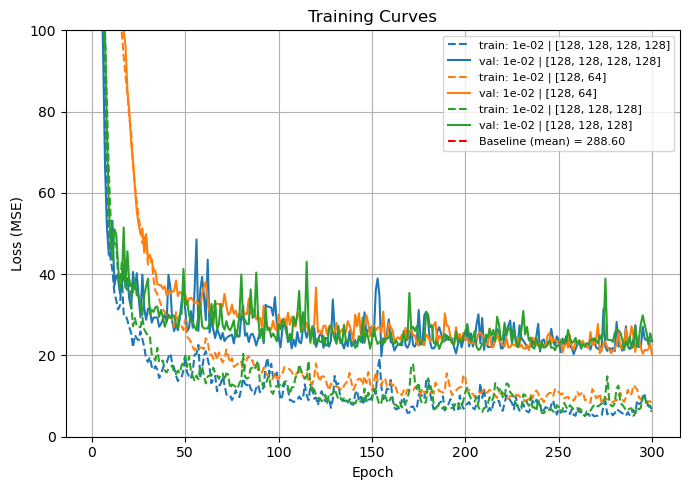

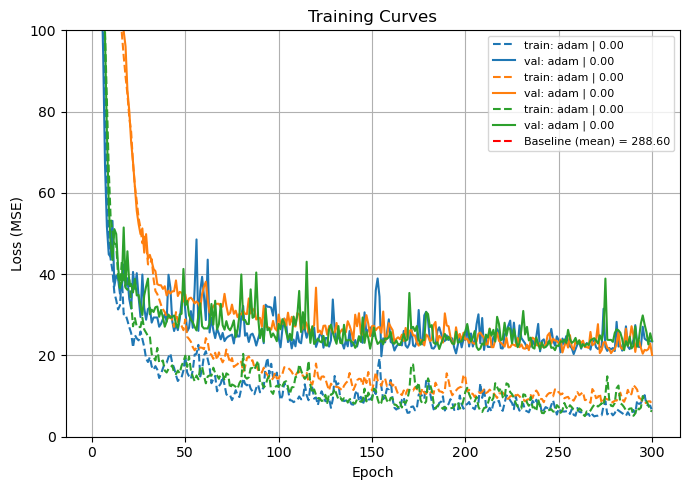

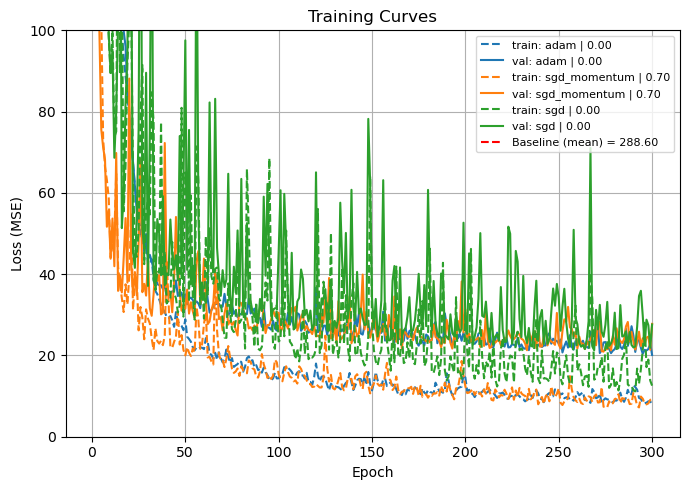

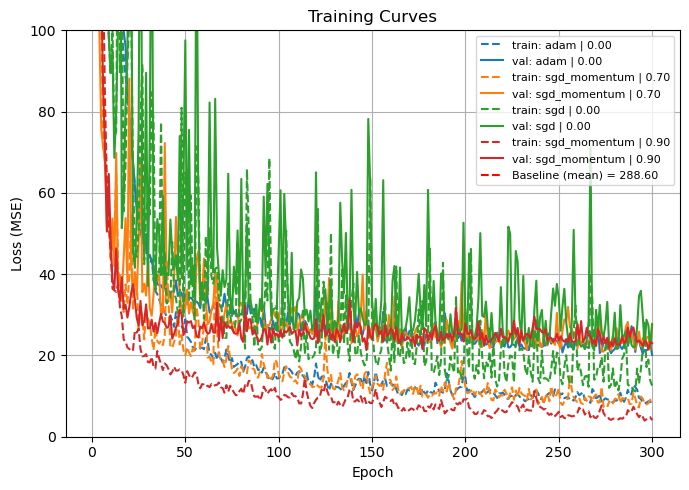

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
def plot_training_curves(results, baseline=True, optimizer_labels=False):
    plt.figure(figsize=(7,5))

    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for i, r in enumerate(results):
        h = r["history"]
        if optimizer_labels:
            label = f"{r['optimizer']} | {r['momentum']:.2f}"
        else:
            label = f"{r['lr']:.0e} | {r['hidden']}"
        
        color = color_cycle[i % len(color_cycle)]

        plt.plot(h["epoch"], h["train_loss"], '--', color=color, label=f"train: {label}")
        plt.plot(h["epoch"], h["val_loss"], '-', color=color, label=f"val: {label}")

    if baseline:
        y_train_all = []
        y_val_all = []
        for _, yb in train_loader:
            y_train_all.append(yb.numpy())
        for _, yb in val_loader:
            y_val_all.append(yb.numpy())
        y_train_all = np.concatenate(y_train_all).squeeze()
        y_val_all = np.concatenate(y_val_all).squeeze()

        baseline_pred = np.full_like(y_val_all, y_train_all.mean())
        baseline_mse = np.mean((y_val_all - baseline_pred) ** 2)

        plt.axhline(baseline_mse, color="red", linestyle="--", lw=1.5, label=f"Baseline (mean) = {baseline_mse:.2f}")

    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.ylim(0, 100) 
    plt.title("Training Curves")
    plt.legend(fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ------ TODO: change/duplicate for your experiments ------

#task 24
top_n2 = min(3, len(results_task_24))
top_results2 = sorted(results_task_24, key=lambda r: r["best_val_loss"])[:top_n2]
plot_training_curves(top_results2, optimizer_labels=False)
plot_training_curves(top_results2, optimizer_labels=True)

#task 3
top_n3 = min(4, len(results_task_32))
top_n33 = min(3, len(results_task_32))
top_results3 = sorted(results_task_32, key=lambda r: r["best_val_loss"])[:top_n3]
top_results33 = sorted(results_task_32, key=lambda r: r["best_val_loss"])[:top_n33]
plot_training_curves(top_results33, optimizer_labels=True)
plot_training_curves(top_results3, optimizer_labels=True)

# ------ end TODO ------

c:\Users\darkl\miniconda3\envs\deeplearningA2\Lib\site-packages\torch\optim\lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


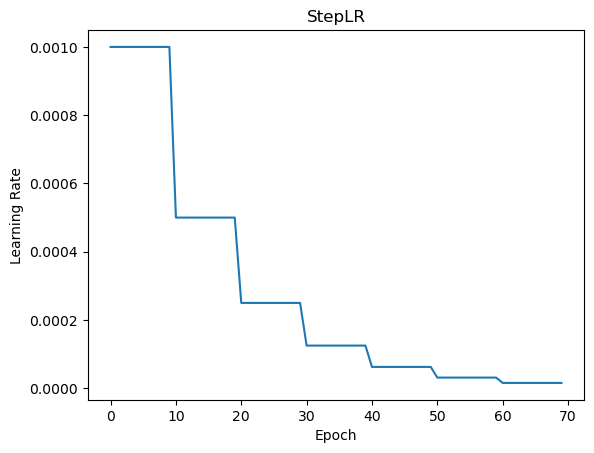

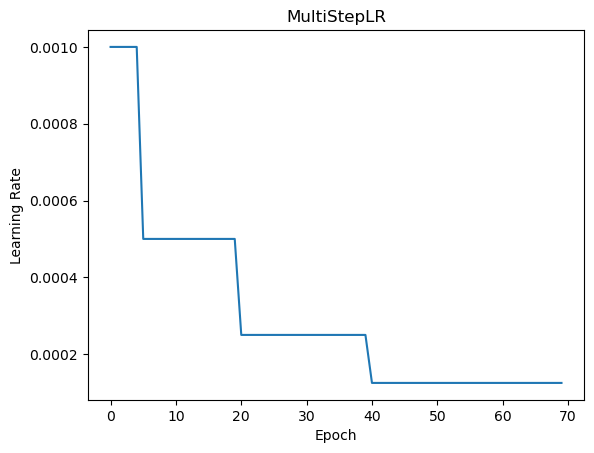

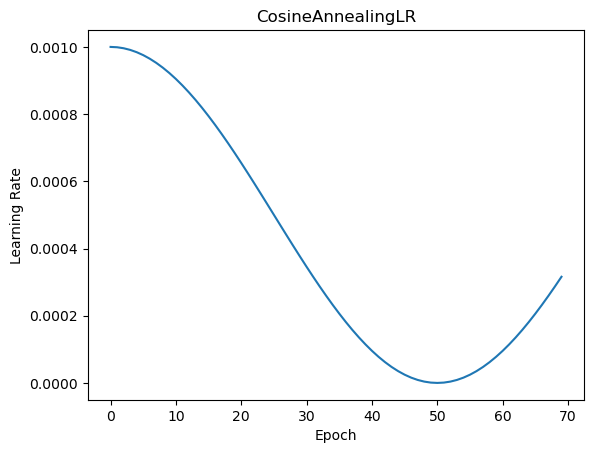

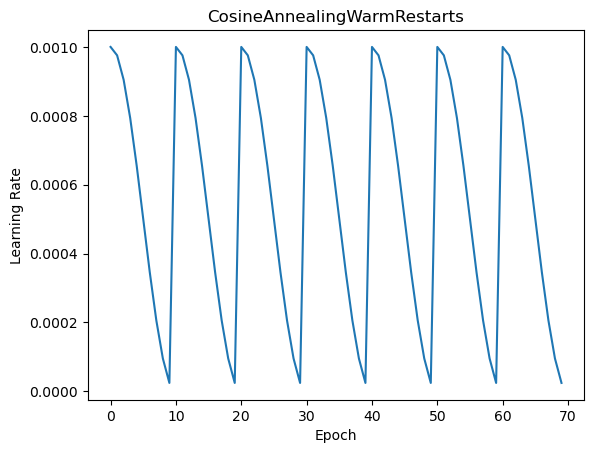

In [151]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
def plot_scheduler_lr(name, scheduler, num_epochs=70):
    lrs = []
    for _ in range(num_epochs):
        lrs.append(scheduler.get_last_lr())
        scheduler.step()

    plt.title(name)
    plt.plot(lrs)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.show()
    
# ------ TODO: implement for your schedulers ------

test_model = OurNN(input_dim=8, hidden_dims=[32])
schedulers = {
    'StepLR': lambda optimizer: StepLR(optimizer, step_size=10, gamma=0.5),
    'MultiStepLR': lambda optimizer: MultiStepLR(optimizer, milestones=[5, 20, 40], gamma=0.5),
    'CosineAnnealingLR': lambda optimizer: CosineAnnealingLR(optimizer, T_max=50),
    'CosineAnnealingWarmRestarts': lambda optimizer: CosineAnnealingWarmRestarts(optimizer, T_0=10),
}

for name, scheduler_int_fn in schedulers.items():
    optimizer = torch.optim.Adam(test_model.parameters(), lr=0.001)
    scheduler = scheduler_int_fn(optimizer)
    plot_scheduler_lr(name, scheduler)
# ------ end TODO ------

### Task 3.3

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
best_arch = [128, 64] 

step_lr_recipe   = lambda opt: StepLR(opt, step_size=10, gamma=0.5)
cosine_lr_recipe = lambda opt: CosineAnnealingLR(opt, T_max=50)
experiments = [
    {"opt": "adam", "lr": 1e-2, "mom": 0.0, "name": "Adam | No Sched", "sched": None},
    {"opt": "adam", "lr": 1e-2, "mom": 0.0, "name": "Adam | StepLR",   "sched": step_lr_recipe},
    {"opt": "adam", "lr": 1e-2, "mom": 0.0, "name": "Adam | Cosine",   "sched": cosine_lr_recipe},
    {"opt": "sgd_momentum", "lr": 1e-4, "mom": 0.9, "name": "SGD | No Sched", "sched": None},
    {"opt": "sgd_momentum", "lr": 1e-4, "mom": 0.7, "name": "SGD | No Sched", "sched": None},
    {"opt": "sgd_momentum", "lr": 1e-4, "mom": 0.9, "name": "SGD | StepLR",   "sched": step_lr_recipe},
    {"opt": "sgd_momentum", "lr": 1e-4, "mom": 0.7, "name": "SGD | StepLR",   "sched": step_lr_recipe},
    {"opt": "sgd_momentum", "lr": 1e-4, "mom": 0.9, "name": "SGD | No Sched", "sched": cosine_lr_recipe},
]
results_sched = []

print("=== RUNNING SCHEDULER TASK ===")
for exp in experiments:
    print(f"\nRunning: {exp['opt']} | LR: {exp['lr']} | Sched: {exp['sched']}")
    res = train_one_model(
        input_dim=8,
        hidden=best_arch,
        lr=exp['lr'],
        max_epochs=300,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer_name=exp['opt'],
        momentum=exp['mom'],
        scheduler_type=exp['sched']
    )
    res["scheduler"] = exp["name"]
    results_sched.append(res)


show_results(results_sched)

=== RUNNING SCHEDULER TASK ===

Running: adam | LR: 0.01 | Sched: None
[[128, 64] | lr=1e-02 | epoch   1/300] train=1267.017249  val=662.332344
[[128, 64] | lr=1e-02 | epoch   2/300] train=367.408215  val=330.126045
[[128, 64] | lr=1e-02 | epoch   3/300] train=262.618556  val=234.818913
[[128, 64] | lr=1e-02 | epoch   4/300] train=203.729776  val=161.572733
[[128, 64] | lr=1e-02 | epoch   5/300] train=171.602447  val=146.184896
[[128, 64] | lr=1e-02 | epoch   6/300] train=149.155988  val=140.391424
[[128, 64] | lr=1e-02 | epoch   7/300] train=137.763968  val=131.221323
[[128, 64] | lr=1e-02 | epoch   8/300] train=132.076235  val=127.676367
[[128, 64] | lr=1e-02 | epoch   9/300] train=127.495572  val=123.664282
[[128, 64] | lr=1e-02 | epoch  10/300] train=120.009389  val=120.980808
[[128, 64] | lr=1e-02 | epoch  11/300] train=115.483459  val=118.325029
[[128, 64] | lr=1e-02 | epoch  12/300] train=112.924511  val=117.955706
[[128, 64] | lr=1e-02 | epoch  13/300] train=109.350734  val=112

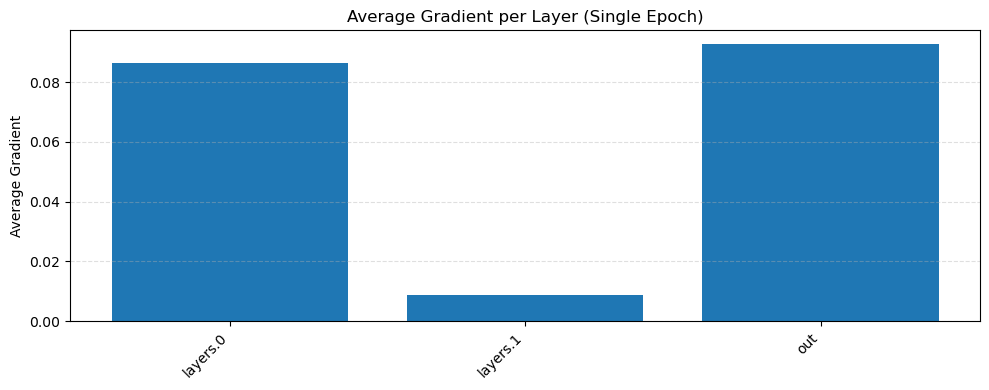

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
def plot_gradients(gradients, epoch=None,  max_xticks=20):
    if epoch is not None:
        gradients=gradients[epoch]
    
    filtered = [d for d in gradients if d['layer'] != 'activation']

    def sort_key(item):
        name = item['layer']
        if name.startswith('layers.'):
            try:
                return int(name.split('.')[1])
            except ValueError:
                return -1
        elif name == 'out':
            return 9999
        else:
            return -1

    filtered.sort(key=sort_key)

    layers = [d['layer'] for d in filtered]
    grads = [d['grad'].item() if torch.is_tensor(d['grad']) else float(d['grad']) for d in filtered]

    plt.figure(figsize=(10, 4))
    plt.bar(range(len(layers)), grads, width=0.8)
    plt.ylabel('Average Gradient')
    plt.title('Average Gradient per Layer (Single Epoch)')
    plt.grid(True, axis='y', linestyle='--', alpha=0.4)

    n_layers = len(layers)
    if n_layers > max_xticks:
        step = max(1, n_layers // max_xticks)
        tick_positions = list(range(0, n_layers, step))
        tick_labels = [layers[i] for i in tick_positions]
    else:
        tick_positions = range(n_layers)
        tick_labels = layers

    plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# ------ TODO: change/duplicate for your experiments ------
plot_gradients(results_sched[0]["history"]["gradients"], -1)
# ------ end TODO ------

# Task 4
### Task 4.1

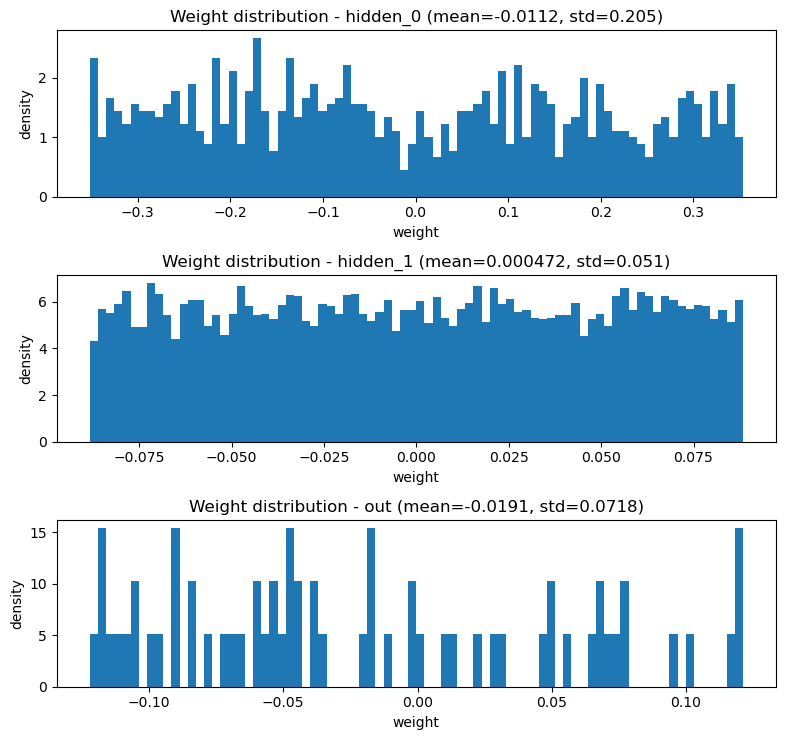

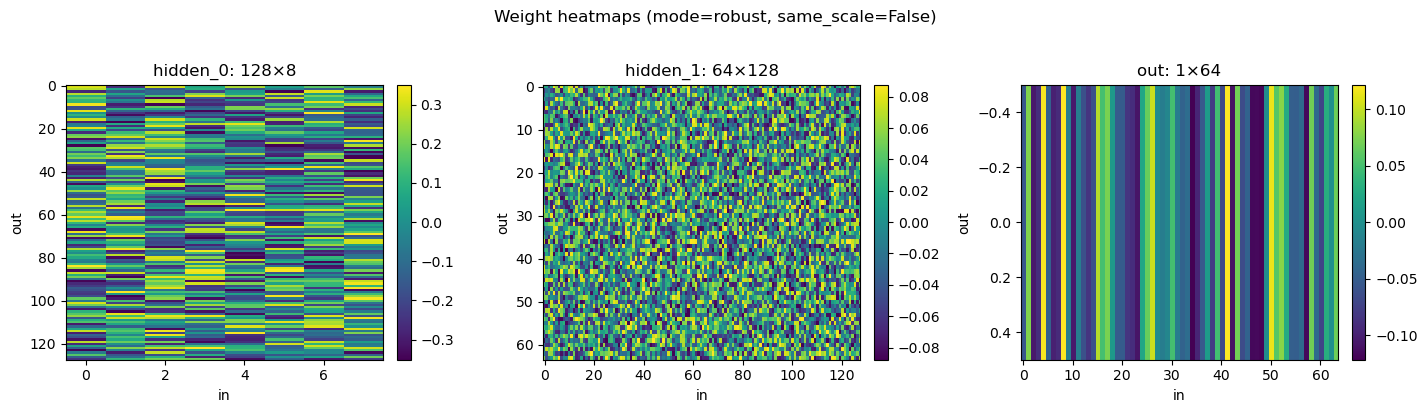

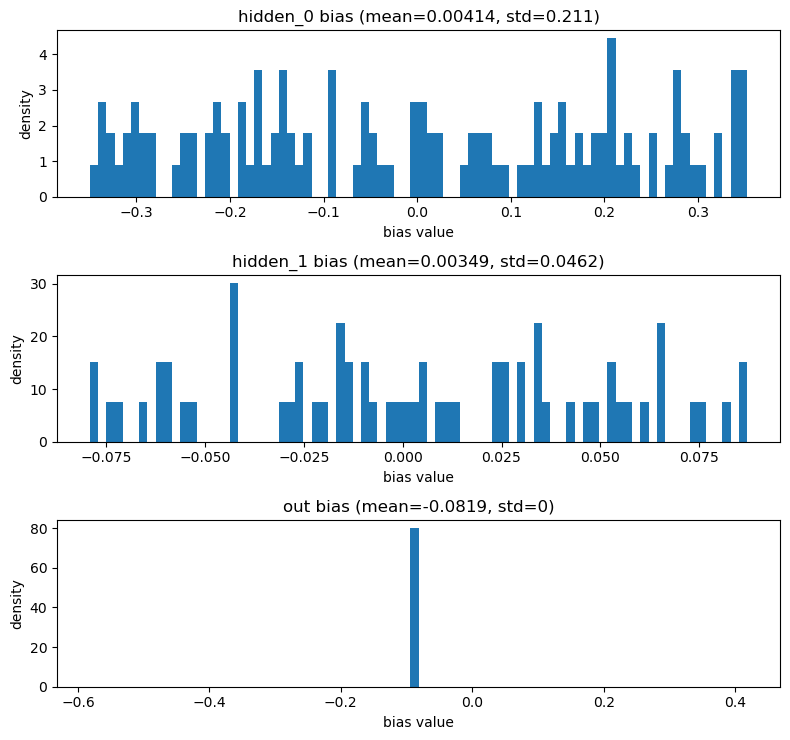

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
def iter_linear_layers(model):
    for i, layer in enumerate(model.layers):
        yield f"hidden_{i}", layer
    yield "out", model.out


def plot_weight_heatmaps(model, mode="robust", q=99.5, same_scale=False):
    stats = []
    Ws = []
    names = []
    with torch.no_grad():
        for name, layer in iter_linear_layers(model):
            W = layer.weight.detach().float().cpu().numpy()
            Ws.append(W); names.append(name)
            absW = np.abs(W)
            if mode == "robust":
                v = np.percentile(absW, q)
            elif mode == "std":
                v = absW.std() * 3.0
            elif mode == "auto":
                v = absW.max()
            else:
                raise ValueError("mode must be robust|std|auto")
            stats.append(max(v, 1e-8))

    if same_scale:
        vmax = float(max(stats))
        vmins = [-vmax]*len(Ws); vmaxs = [vmax]*len(Ws)
    else:
        vmins = [-v for v in stats]; vmaxs = stats

    n = len(Ws)
    fig, axes = plt.subplots(1, n, figsize=(4.8*n, 4))
    if n == 1: axes = [axes]
    for ax, W, name, vmin, vmax in zip(axes, Ws, names, vmins, vmaxs):
        im = ax.imshow(W, vmin=vmin, vmax=vmax, aspect="auto", interpolation="nearest")
        ax.set_title(f"{name}: {W.shape[0]}×{W.shape[1]}")
        ax.set_xlabel("in"); ax.set_ylabel("out")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.suptitle(f"Weight heatmaps (mode={mode}, same_scale={same_scale})", y=1.02)
    fig.tight_layout()


def plot_bias_histograms(model, bins=80):
    """Plot histograms of all linear layer biases."""
    with torch.no_grad():
        layers = list(iter_linear_layers(model))
        fig, axes = plt.subplots(len(layers), 1, figsize=(8, 2.5 * len(layers)))
        if len(layers) == 1:
            axes = [axes]

        for ax, (name, layer) in zip(axes, layers):
            if layer.bias is None:
                ax.set_title(f"{name}: no bias")
                ax.axis("off")
                continue

            b = layer.bias.detach().float().cpu().numpy()
            ax.hist(b, bins=bins, density=True)
            ax.set_title(f"{name} bias (mean={b.mean():.3g}, std={b.std():.3g})")
            ax.set_xlabel("bias value")
            ax.set_ylabel("density")

        fig.tight_layout()

def plot_weight_histograms(model, bins=80):
    with torch.no_grad():
        n = sum(1 for _ in iter_linear_layers(model))
        fig, axes = plt.subplots(n, 1, figsize=(8, 2.5*n))
        if n == 1: axes = [axes]
        for ax, (name, layer) in zip(axes, iter_linear_layers(model)):
            w = layer.weight.detach().float().cpu().flatten().numpy()
            ax.hist(w, bins=bins, density=True)
            ax.set_title(f"Weight distribution - {name} (mean={w.mean():.3g}, std={w.std():.3g})")
            ax.set_xlabel("weight"); ax.set_ylabel("density")
        fig.tight_layout()


# ------ TODO: change/duplicate for your experiments ------
model = OurNN(input_dim=8, hidden_dims=[128, 64]).to(device)
plot_weight_histograms(model)
plot_weight_heatmaps(model, mode="robust", q=99.5, same_scale=False)
plot_bias_histograms(model)
# ------ end TODO ------

### Task 4.2

=== TASK 4.2: TRAINED WEIGHTS ===
[[128, 64] | lr=1e-02 | epoch   1/300] train=1267.017249  val=662.332344
[[128, 64] | lr=1e-02 | epoch   2/300] train=367.408215  val=330.126045
[[128, 64] | lr=1e-02 | epoch   3/300] train=262.618556  val=234.818913
[[128, 64] | lr=1e-02 | epoch   4/300] train=203.729776  val=161.572733
[[128, 64] | lr=1e-02 | epoch   5/300] train=171.602447  val=146.184896
[[128, 64] | lr=1e-02 | epoch   6/300] train=149.155988  val=140.391424
[[128, 64] | lr=1e-02 | epoch   7/300] train=137.763968  val=131.221323
[[128, 64] | lr=1e-02 | epoch   8/300] train=132.076235  val=127.676367
[[128, 64] | lr=1e-02 | epoch   9/300] train=127.495572  val=123.664282
[[128, 64] | lr=1e-02 | epoch  10/300] train=120.009389  val=120.980808
[[128, 64] | lr=1e-02 | epoch  11/300] train=115.483459  val=118.325029
[[128, 64] | lr=1e-02 | epoch  12/300] train=112.924511  val=117.955706
[[128, 64] | lr=1e-02 | epoch  13/300] train=109.350734  val=112.036421
[[128, 64] | lr=1e-02 | epoch

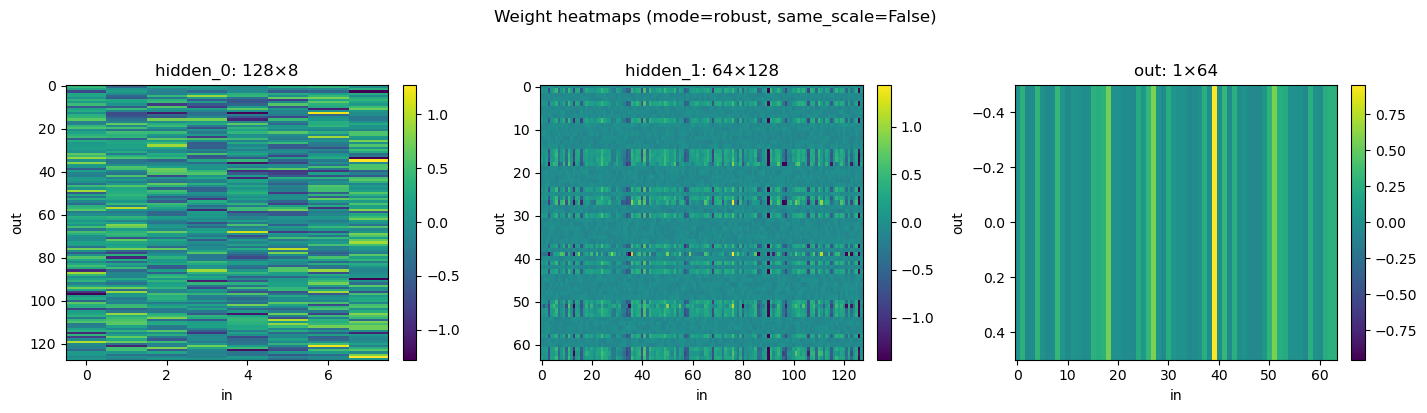

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
print("=== TASK 4.2: TRAINED WEIGHTS ===")


train_result = train_one_model(
    input_dim=8,
    hidden=[128, 64],
    lr=1e-2,
    max_epochs=300,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer_name="adam",
    momentum=0.0
)

trained_model = train_result["model"]

plot_weight_heatmaps(trained_model, mode="robust", q=99.5, same_scale=False)

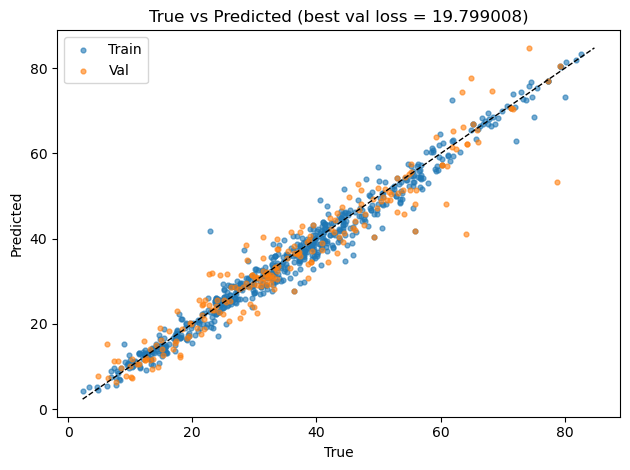

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
def scatterplot(results):
    best = min(results, key=lambda r: r["best_val_loss"])
    best_model = best["model"].eval()

    def preds_and_targets(loader, model, device):
        ys, yhats = [], []
        with torch.no_grad():
            for xb, yb in loader:
                xb = xb.to(device)
                yb = yb.to(device)
                phat = model(xb)
                ys.append(yb.detach().cpu().numpy())
                yhats.append(phat.detach().cpu().numpy())
        y  = np.concatenate(ys, axis=0).squeeze()
        yhat = np.concatenate(yhats, axis=0).squeeze()
        return y, yhat

    y_tr, yhat_tr = preds_and_targets(train_loader, best_model, device)
    y_va, yhat_va = preds_and_targets(val_loader,   best_model, device)


    mn = float(min(y_tr.min(), y_va.min(), yhat_tr.min(), yhat_va.min()))
    mx = float(max(y_tr.max(), y_va.max(), yhat_tr.max(), yhat_va.max()))

    plt.figure()
    plt.scatter(y_tr, yhat_tr, s=12, alpha=0.6, label="Train")
    plt.scatter(y_va, yhat_va, s=12, alpha=0.6, label="Val")
    plt.plot([mn, mx], [mn, mx], lw=1, linestyle="--", color="black")
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.legend()
    plt.title(f"True vs Predicted (best val loss = {best['best_val_loss']:.6f})")
    plt.tight_layout()
    plt.show()

# ------ TODO: change/duplicate for your experiments ------
scatterplot(results_task_2)
# ------ end TODO ------

# Task 5
### Task 5.1

[{'layer': 'out', 'grad': 0.09273327887058258}, {'layer': 'layers.1', 'grad': 0.00868871621787548}, {'layer': 'layers.0', 'grad': 0.08656787872314453}]


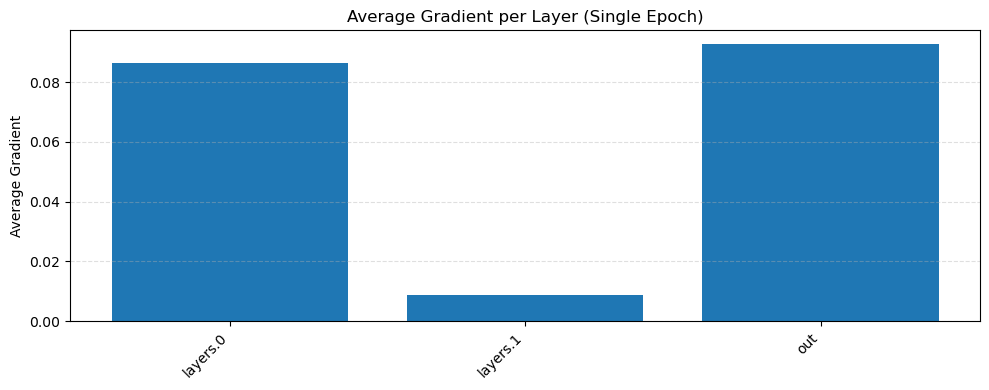

In [167]:
best = min(results_task_31, key=lambda r: r["best_val_loss"])
print(best["history"]["gradients"][-1])
plot_gradients(best["history"]["gradients"], epoch=-1)

### Task 5.2

Training network with depth = 1 (hidden dims = [32])
Training network with depth = 2 (hidden dims = [32, 32])
Training network with depth = 4 (hidden dims = [32, 32, 32, 32])
Training network with depth = 8 (hidden dims = [32, 32, 32, 32, 32, 32, 32, 32])
Training network with depth = 16 (hidden dims = [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32])
Training network with depth = 32 (hidden dims = [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32])
Training network with depth = 64 (hidden dims = [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32])
Training network with depth = 128 (hidden dims = [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 

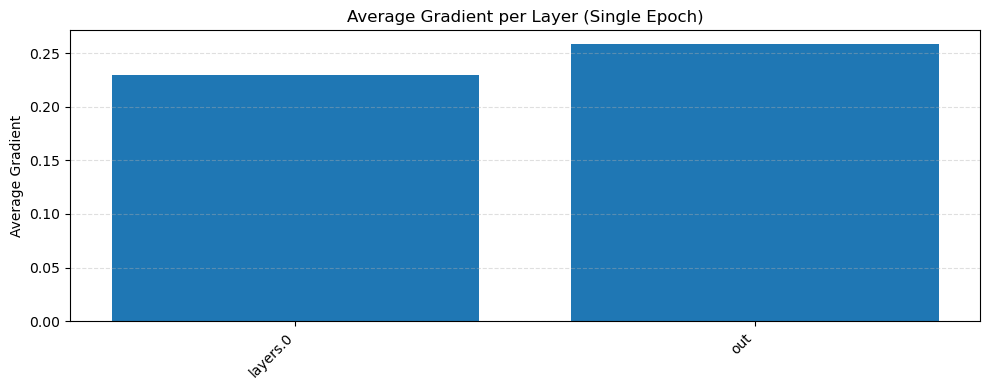

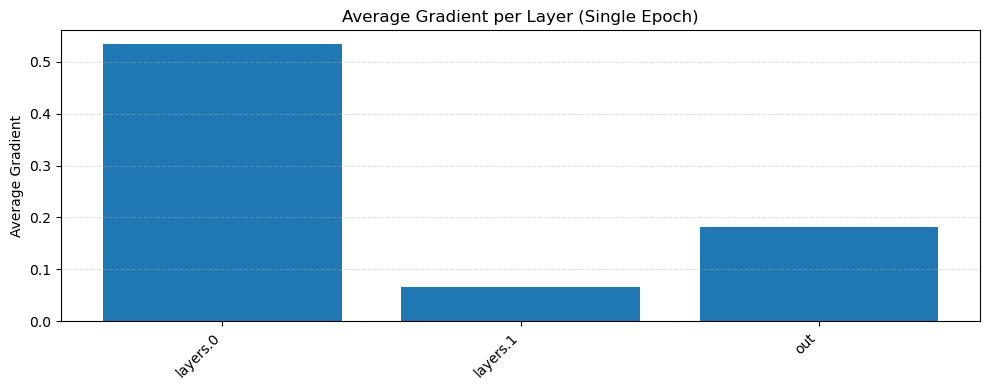

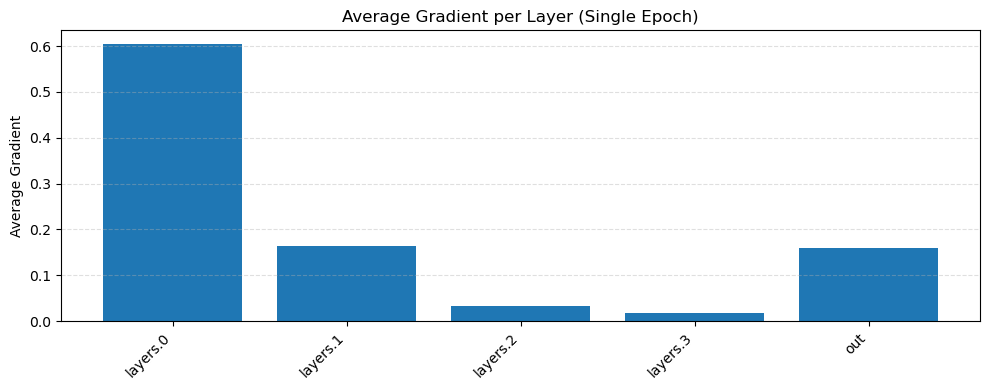

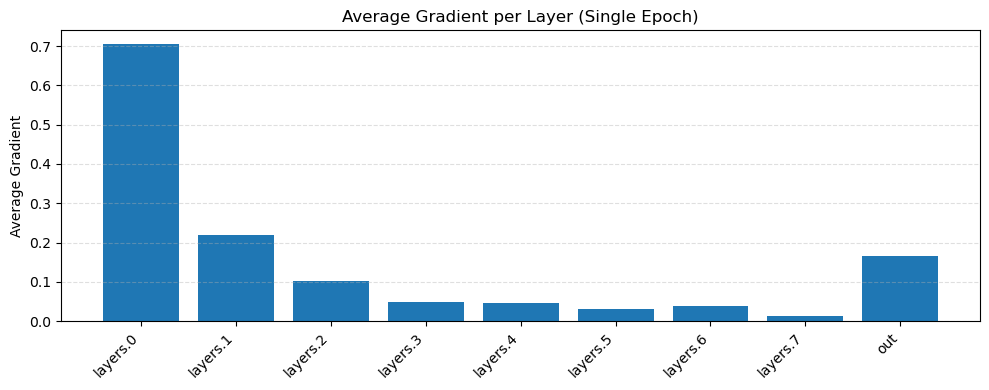

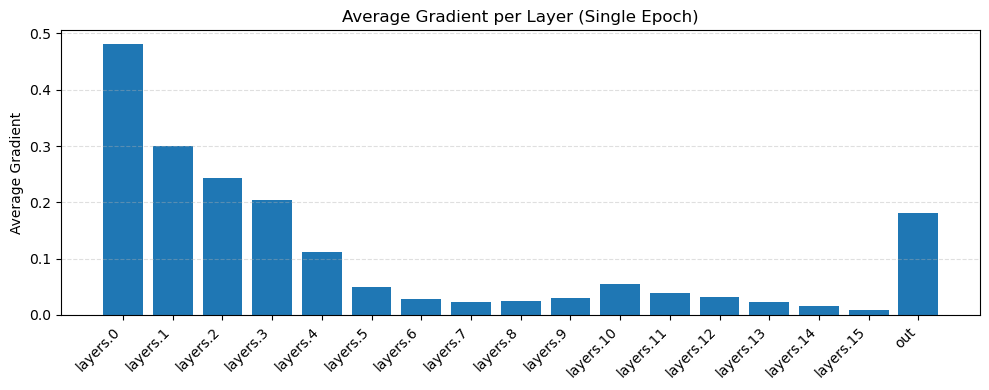

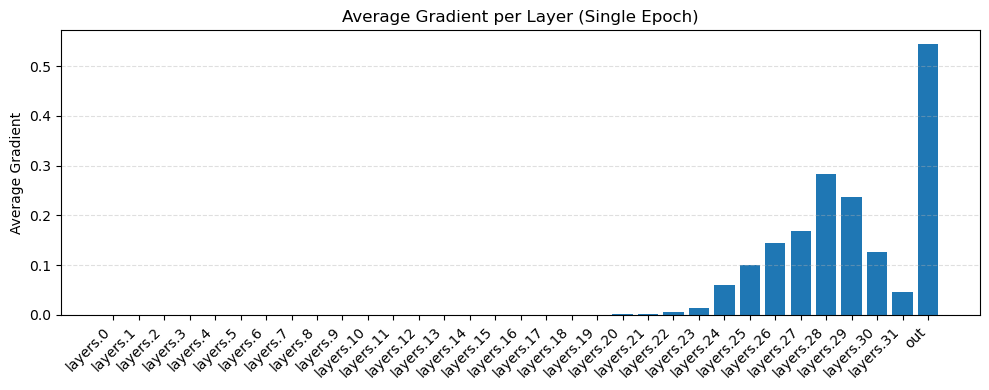

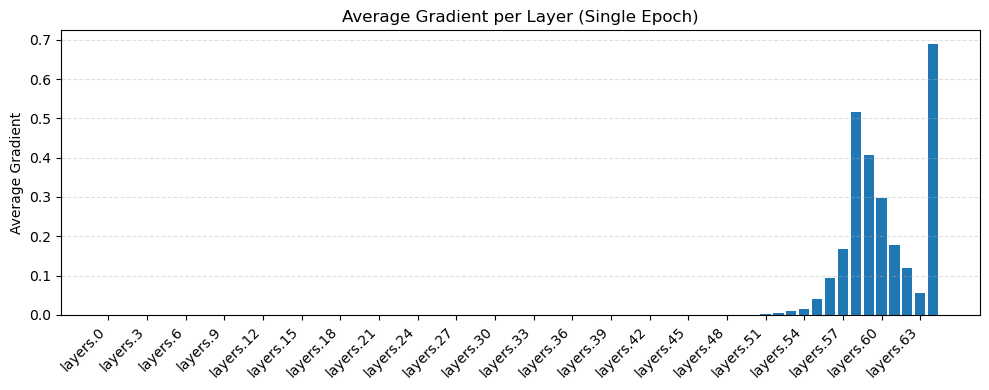

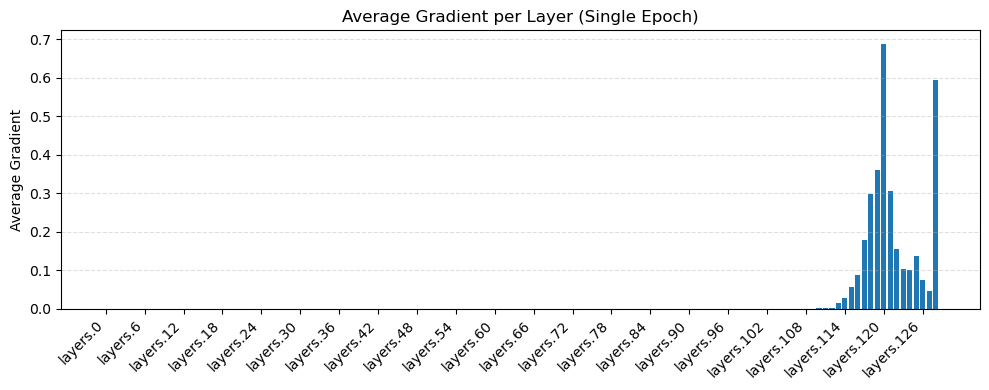

In [ ]:

depths = [1, 2, 4, 8, 16, 32, 64, 128]
width  = 32
max_epochs_depth = 100
lr_depth = 1e-2
optimizer_name_depth = "adam"
momentum_depth = 0.0

depth_results = []

for d in depths:
    print(f"Training network with depth = {d} (hidden dims = {[width]*d})")
    seed = 42
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    out = train_one_model(
        input_dim=X_train_t.shape[1],
        hidden=[width] * d,
        lr=lr_depth,
        max_epochs=max_epochs_depth,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer_name=optimizer_name_depth,
        momentum=momentum_depth,
        verbose=False,
    )
    out["depth"] = d
    depth_results.append(out)

for res in depth_results:
    d = res["depth"]
    plot_gradients(res["history"]["gradients"], epoch=-1)

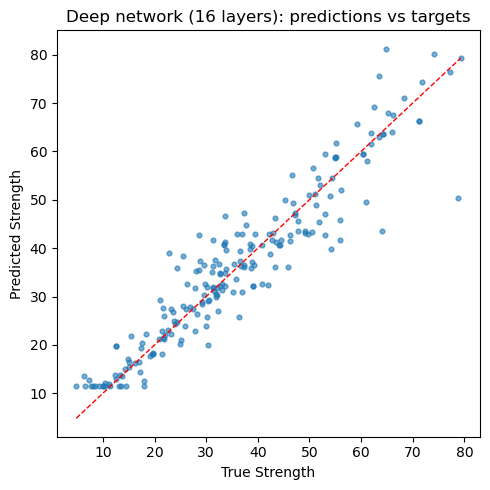

Deep model val loss: 31.778690338134766


In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
deep_result = max(depth_results, key=lambda r: r["depth"])
deep_model = deep_result["model"].eval()

ys, yhats = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        phat = deep_model(xb)
        ys.append(yb.cpu().numpy())
        yhats.append(phat.cpu().numpy())

y_true  = np.concatenate(ys, axis=0).squeeze()
y_pred  = np.concatenate(yhats, axis=0).squeeze()

mn, mx = y_true.min(), y_true.max()

plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, alpha=0.6, s=12)
plt.plot([mn, mx], [mn, mx], "r--", lw=1)
plt.xlabel("True Strength")
plt.ylabel("Predicted Strength")
plt.title(f"Deep network ({deep_result['depth']} layers): predictions vs targets")
plt.tight_layout()
plt.show()

print("Deep model val loss:", deep_result["best_val_loss"])

# Task 6

[[128, 64] | lr=1e-02 | epoch   1/300] train=1086.525334  val=321.172488
[[128, 64] | lr=1e-02 | epoch   2/300] train=325.247486  val=193.356462
[[128, 64] | lr=1e-02 | epoch   3/300] train=213.184503  val=167.432111
[[128, 64] | lr=1e-02 | epoch   4/300] train=163.213385  val=147.218150
[[128, 64] | lr=1e-02 | epoch   5/300] train=145.385451  val=136.553623
[[128, 64] | lr=1e-02 | epoch   6/300] train=134.516897  val=128.786892
[[128, 64] | lr=1e-02 | epoch   7/300] train=128.672865  val=122.195953
[[128, 64] | lr=1e-02 | epoch   8/300] train=123.936890  val=117.107738
[[128, 64] | lr=1e-02 | epoch   9/300] train=117.852320  val=113.724337
[[128, 64] | lr=1e-02 | epoch  10/300] train=115.114616  val=112.527108
[[128, 64] | lr=1e-02 | epoch  11/300] train=111.799388  val=106.981090
[[128, 64] | lr=1e-02 | epoch  12/300] train=107.496774  val=103.696279
[[128, 64] | lr=1e-02 | epoch  13/300] train=105.222949  val=100.335404
[[128, 64] | lr=1e-02 | epoch  14/300] train=100.915301  val=97

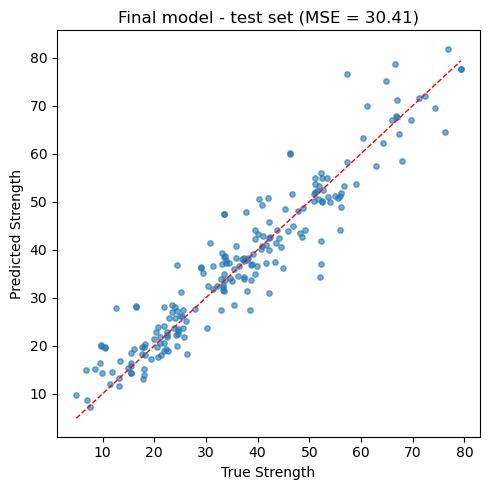

In [185]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
X_trainval_t = torch.cat([X_train_t, X_vld_t], dim=0)
y_trainval_t = torch.cat([y_train_t, y_vld_t], dim=0)

trainval_dataset = TensorDataset(X_trainval_t, y_trainval_t)
trainval_loader  = DataLoader(trainval_dataset,
                              batch_size=batch_size,
                              shuffle=True)

final_result = train_one_model(
    input_dim=X_trainval_t.shape[1],
    hidden=[128, 64],
    lr=1e-2,
    max_epochs=300,
    train_loader=trainval_loader,
    val_loader=trainval_loader,
    optimizer_name="adam",
    momentum=0.0
)

final_model = final_result["model"]

criterion = nn.MSELoss()
final_model.eval()

with torch.no_grad():
    y_test_pred = final_model(X_test_t.to(device))
    test_loss = criterion(y_test_pred, y_test_t.to(device)).item()

print(f"Final test MSE: {test_loss:.4f}")

y_test_pred_np = y_test_pred.cpu().numpy().squeeze()
y_test_true_np = y_test_t.cpu().numpy().squeeze()

mn, mx = y_test_true_np.min(), y_test_true_np.max()

plt.figure(figsize=(5,5))
plt.scatter(y_test_true_np, y_test_pred_np, alpha=0.6, s=15)
plt.plot([mn, mx], [mn, mx], "r--", lw=1)
plt.xlabel("True Strength")
plt.ylabel("Predicted Strength")
plt.title(f"Final model - test set (MSE = {test_loss:.2f})")
plt.tight_layout()
plt.show()
